In [45]:
image_path = "ELEKTROKOTER HATA KODLARI 06.09.2024/ANJIO/ANJIO 8/WhatsApp Görsel 2024-09-06 saat 17.39.00_9a0c0851.jpg"

Hata kodları:
B0B
B17
B17


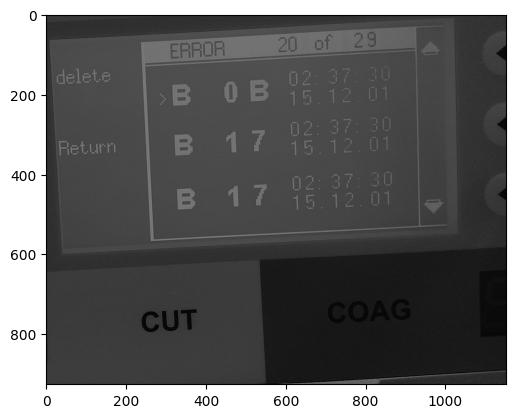

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import re
from skimage import io
import os

# Renk sınır setleri
blue_ranges = [
    (np.array([110, 130, 40]), np.array([145, 255, 255])),  # İlk deneme için
    (np.array([105, 80, 30]), np.array([140, 255, 255])),  # İkinci deneme için
    (np.array([100, 40, 20]), np.array([140, 255, 255])),  # Üçüncü deneme için
]

# Görsel dosyası var mı kontrol edelim
if not image_path:
    print("Görsel dosyası belirtilmedi.")
    exit()
    assert False
if not os.path.exists(image_path):
    print("Görsel dosyası bulunamadı.")
    exit()
    assert False

# Görseli yükleyelim
image = cv2.imread(image_path)

# Dinamik renk sınırı denemesi için flag
screen_found = False
matches = []

# Renk sınırları döngüsü
for lower_blue, upper_blue in blue_ranges:
    # Görseli HSV renk alanına çevirelim
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Renk aralığına göre maske oluşturalım
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # Maskeye göre orijinal görseldeki ilgili alanları çıkartalım
    result = cv2.bitwise_and(image, image, mask=mask)

    # Gri tonlama yapalım
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    # Kenar tespiti yaparak bölgeyi bulmaya çalışalım
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ekranın hata kodlarını tespit etmek için doğru büyüklükte dikdörtgeni bulalım
    screen_contour = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 400 and h > 200:  # Boyut filtreleme
            screen_contour = contour
            break

    # Eğer ekran tespit edildiyse, bu bölgeyi kırpalım
    if screen_contour is not None:
        x, y, w, h = cv2.boundingRect(screen_contour)
        cropped_image = image[y : y + h, x : x + w]

        # Görüntü iyileştirmeleri
        gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

        # Keskinleştirme filtresi (sharpening)
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened = cv2.filter2D(gray_cropped, -1, kernel)

        # Kontras arttırma
        alpha = 0.55  # Kontras arttırma faktörü
        beta = 1.3  # Parlaklık arttırma faktörü
        sharpened = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

        # EasyOCR ile OCR işlemi
        reader = easyocr.Reader(["en"], gpu=True)
        ocr_result = reader.readtext(sharpened, detail=0)

        # OCR ile okunan ham metni ekrana yazdıralım
        # print("OCR ile tespit edilen ham metin:\n", ocr_result)

        # '€' karakterini 'C' olarak değiştirme
        for i in range(len(ocr_result)):
            ocr_result[i] = ocr_result[i].replace("€", "C")
            ocr_result[i] = ocr_result[i].replace("o", "0")
            ocr_result[i] = ocr_result[i].replace("O", "0")

        # Hata kodlarını temizleme (whitespace ve özel karakter temizleme)
        clean_result = [text.upper() for text in ocr_result]
        clean_result = [re.sub(r"[^A-Za-z0-9 ]", "", text) for text in ocr_result]
        clean_result = [
            "".join(text.split()) for text in clean_result
        ]  # Whitespace'leri kaldır

        # print("OCR ile tespit edilen temiz metin:\n", clean_result)

        # Hata kodlarını bulmak için 3 farklı durumu kontrol eden algoritma
        i = 0
        while i < len(clean_result):
            # 1. Durum: Tek başına 'A', 'B', 'C' ve sonraki eleman 2 karakterli 'XX' ise
            if clean_result[i] in ["A", "B", "C", "4"]:
                if i + 1 < len(clean_result) and re.match(
                    r"^[A-Z0-9]{2}$", clean_result[i + 1]
                ):
                    combined_code = clean_result[i] + clean_result[i + 1]
                    matches.append(combined_code)
                    i += 1  # İki elemanı birleştirdikten sonra bir adım atlayarak devam et
                elif len(clean_result[i + 1]) > 2:
                    combined_code = (
                        clean_result[i] + clean_result[i + 1][:2]
                    )  # İlk iki karakter
                    matches.append(combined_code)
                    i += 1
            # 2. Durum: 'AX', 'BX', 'CX' formatında olup, sonraki eleman 'X' ise
            elif re.match(r"^[A-C][A-Z0-9]{1}$", clean_result[i]):
                if i + 1 < len(clean_result) and re.match(
                    r"^[A-Z0-9]{1}$", clean_result[i + 1]
                ):
                    combined_code = clean_result[i] + clean_result[i + 1]
                    matches.append(combined_code)
                    i += 1  # İki elemanı birleştirdikten sonra bir adım atlayarak devam et
            # 3. Durum: Tek başına 'A', 'B', 'C' ise ve, sonraki eleman 'X', ondan sonraki eleman da 'X' ise
            elif clean_result[i] in ["A", "B", "C", "4"]:
                if (
                    i + 2 < len(clean_result)
                    and re.match(r"^[A-Z0-9]$", clean_result[i + 1])
                    and re.match(r"^[A-Z0-9]$", clean_result[i + 2])
                ):
                    combined_code = (
                        clean_result[i] + clean_result[i + 1] + clean_result[i + 2]
                    )
                    matches.append(combined_code)
                    i += 2  # Üç elemanı birleştirdikten sonra iki adım atlayarak devam et
            elif re.match(r"^[A-D][A-Z0-9]{2}$", clean_result[i]):
                matches.append(clean_result[i])
            i += 1

        if len(matches) > 0:  # Ekran tespit edilip hata kodları bulundu
            screen_found = True
            break  # Hata kodları bulunduysa diğer denemelere geçmeye gerek yok

# Eğer ekran ve hata kodları tespit edildiyse
to_be_removed_codes = ["CUT", "COA", "OAG", "ACU"]
# detect full numeric codes and add them to the to be removed list
for match in matches:
    if match.isnumeric():
        to_be_removed_codes.append(match)
matches = [match for match in matches if match not in to_be_removed_codes]

is_errors_found = len(matches) > 0
if is_errors_found:
    print("Hata kodları:")
    for match in matches:
        print(match)
else:
    print("Hata kodu bulunamadı.")

# Kesilen bölgeyi ve OCR sonucunu gösterelim
plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
plt.show()

if not screen_found:
    print("Ekran bölgesi tespit edilemedi.")